## Лабораторна робота №7: Сценарії обробки багатоспектральних супутникових зображень
### *виконала студентка групи ФБ-33 Журавльова Марія*

**Мета роботи:** ознайомитися з основними принципами обробки даних дистанційного зондування Землі (ДЗЗ) та можливостями мови Python для обробки геопросторової інформації, а саме, багатоспектральних супутникових зображень засобами бібліотеки абстракції супутникової інформації (GDAL).

**Постановка задачі:**
Лабораторна робота має дві частини. У першій (простішій) частині (пп. 1–2) необхідно працювати з даними Sentinel-2, які необхідно завантажити за допомогою Copernicus Scihub за ідентифікаторами (список ідентифікаторів дивись нижче) або скористатися архівом, що надається викладачем. У другій (складнішій) частині (п. 4) потрібно також самостійно завантажити дані Landsat з порталу USGS. Для цього підійдуть будь які 2 сусідніх знімки Ladsat-8 з відсотком хмарності до 30%, (рекомендовані ідентифікатори наведено внизу у п. 3).

In [5]:
import os
from sentinelhub import SHConfig
from sentinelhub.aws.request import download_safe_format
import zipfile
import shutil
import subprocess
import sys
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from osgeo import gdal, osr
from tqdm import tqdm
import geopandas as gpd
from shapely import wkt
print("Setup Complete")

Setup Complete


1. Завантажити необхідні дані Sentinel-2 (або з Copernicus SciHub, або з Google-диска). За допомогою бібліотеки sentinelhub написати скрипт для завантаження супутникових знімків Sentinel-2, які покривають Київ (ROI — POLYGON((29.073321247506765 49.845775018245774, 31.986007792928522 49.845775018245774, 31.986007792928522 51.278667808079206, 29.073321247506765 51.278667808079206, 29.073321247506765 49.845775018245774)) ).

Список ідентифікаторів Sentinel-2:

– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206

– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206

In [ ]:
my_dir = os.path.join(os.getcwd(), "lab7")
os.makedirs(my_dir, exist_ok=True)

config = SHConfig()
config.aws_access_key_id = '???'
config.aws_secret_access_key = '???'
config.save()

def download_sentinel_2(product_id):
    try:
        print(f"Завантаження: {product_id}")
        download_safe_format(
            product_id=product_id,
            folder=my_dir,           
            redownload=False
        )
        print(f"{product_id} завантажено.")
    except Exception as e:
        print(f"!!! Помилка під час завантаження {product_id}: {e}")

product_ids = {
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
}

for product_id in product_ids:
    download_sentinel_2(product_id)

Завантаження: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206


C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\request.py:245: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\data.py:353: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\data_safe.py:331: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206 завантажено.
Завантаження: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206


C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\request.py:245: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\data.py:353: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
C:\Users\User\anaconda3\Lib\site-packages\sentinelhub\aws\data_safe.py:331: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206 завантажено.


2. Засобами командного рядка операційної системи (демонстраційні приклади розглянуті для ОС Windows), а також за допомогою бінаріїв бібліотеки GDAL розробити автоматичний сценарій, який здійснюватиме обробку даних ДЗЗ, відповідно до поставлених завдань. Для виконання команд gdal у сценарії Python можна використовувати бібліотеки os та command.
Над завантаженими даними Sentinel-2 відпрацювати наступні дії.

- Розпакування наборів архівів з продуктами ДЗЗ в новостворені папки, назви яких відповідатимуть ідентифікаторам зображень.

In [7]:
def extract_sentinel_archives(path_dir):
    archive_extensions = ('.zip',)
    archives = [f for f in os.listdir(path_dir) if f.lower().endswith(archive_extensions)]

    for archive in archives:
        archive_path = os.path.join(path_dir, archive)
        product_id = os.path.splitext(archive)[0]
        extract_to = os.path.join(path_dir, product_id)

        if not os.path.exists(extract_to):
            os.makedirs(extract_to)

        print(f"Розпаковка архіву: {archive}")
        try:
            with zipfile.ZipFile(archive_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Успішно розпаковано у: {extract_to}")
        except Exception as e:
            print(f"Помилка при розпакуванні {archive}: {e}")

def rename_safe_folders(path_dir):
    for item in os.listdir(path_dir):
        full_path = os.path.join(path_dir, item)
        if os.path.isdir(full_path) and item.endswith(".SAFE"):
            product_id = item.replace(".SAFE", "")
            new_path = os.path.join(path_dir, product_id)
            if not os.path.exists(new_path):
                shutil.move(full_path, new_path)
                print(f"{item} -> {product_id}")
            else:
                print(f"Папка {new_path} вже існує")

path_dir = r"C:\Users\User\Desktop\university\lab7"
extract_sentinel_archives(path_dir)
rename_safe_folders(path_dir)

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE -> S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE -> S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206


- Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.

In [8]:
def process_product(product_dir):
    bands = {}
    for root, _, files in os.walk(product_dir):
        for f in files:
            if f.endswith(".jp2"):
                if "_B02_10m" in f:
                    bands['B02'] = os.path.join(root, f)
                elif "_B03_10m" in f:
                    bands['B03'] = os.path.join(root, f)
                elif "_B04_10m" in f:
                    bands['B04'] = os.path.join(root, f)
                elif "_B08_10m" in f:
                    bands['B08'] = os.path.join(root, f)

    required_keys = ["B02", "B03", "B04", "B08"]
    missing = [key for key in required_keys if key not in bands]
    if missing:
        print(f"Пропущено: {product_dir} — відсутні канали: {', '.join(missing)}")
        return

    tile_id = None
    for part in product_dir.split('_'):
        if part.startswith('T') and len(part) == 6:
            tile_id = part
            break

    if not tile_id:
        tile_id = "unknown"

    output_file = os.path.join(product_dir, f"concat_{tile_id}.tif")

    gdal_path = r"C:\Users\User\anaconda3\Scripts\gdal_merge.py"
    cmd = [
        sys.executable,
        gdal_path,
        "-o", output_file,
        "-separate",
        bands["B04"], bands["B03"], bands["B02"], bands["B08"]
    ]

    print(f"Створення: {output_file}")
    try:
        subprocess.run(cmd, check=True)
        print(f"Успішно створено: {output_file}")
    except Exception as e:
        print(f"!!! Помилка: {e}")
        
process_product(r"C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206")
process_product(r"C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206")

Створення: C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206\concat_T36UUA.tif
Успішно створено: C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206\concat_T36UUA.tif
Створення: C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\concat_T36UUB.tif
Успішно створено: C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\concat_T36UUB.tif


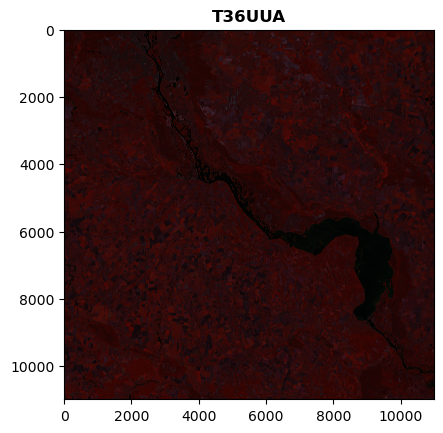

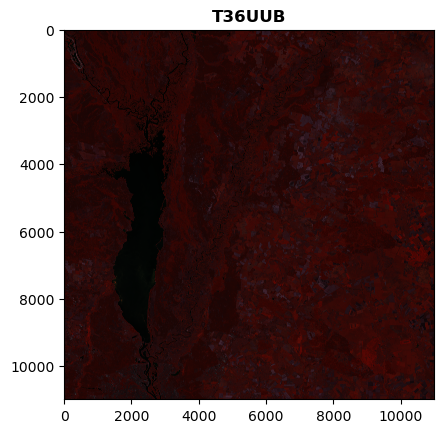

In [10]:
tiles = {
    tag: rasterio.open(
        fr'C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UU{tag}_20190821T115206\concat_T36UU{tag}.tif'
    )
    for tag in ['A', 'B']
}

for tag, img in tiles.items():
    show(img.read([4, 2, 1]), adjust=True, title=f'T36UU{tag}')

- Перепроектування супутникового зображення у проєкцію 4326.

In [11]:
def reproject_4326(input_file, output_file):
    try:
        gdal.Warp(
            output_file,
            input_file,
            dstSRS='EPSG:4326',
        )
        print(f"Перепроектовано: {os.path.basename(input_file)}")
    except Exception as e:
        print(f"!!! Помилка при перепроектуванні {input_file}: {e}")

for tag in ['A', 'B']:
    input_file = fr"C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UU{tag}_20190821T115206\concat_T36UU{tag}.tif"
    output_file = fr"C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UU{tag}_20190821T115206\concat_T36UU{tag}_4326.tif"
    reproject_4326(input_file, output_file)

Перепроектовано: concat_T36UUA.tif
Перепроектовано: concat_T36UUB.tif


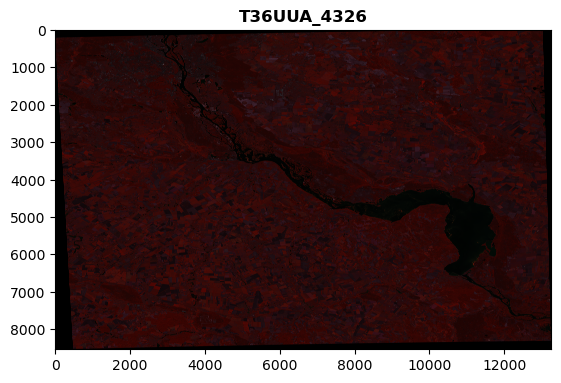

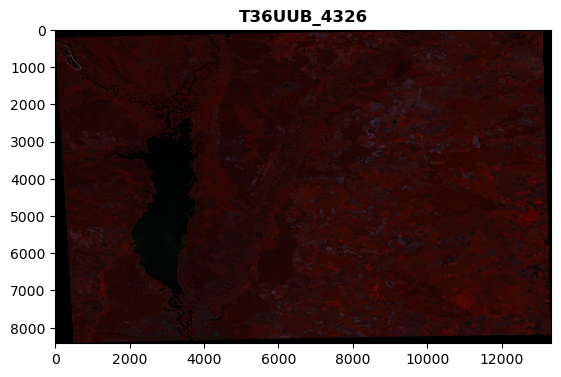

In [12]:
tiles_4326 = {
    tag: rasterio.open(
        fr'C:\Users\User\Desktop\university\lab7\S2A_MSIL2A_20190821T085601_N0213_R007_T36UU{tag}_20190821T115206\concat_T36UU{tag}_4326.tif'
    )
    for tag in ['A', 'B']
}

for tag, img in tiles_4326.items():
    show(img.read([4, 2, 1]), adjust=True, title=f'T36UU{tag}_4326')

- Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

In [13]:
def concat_all(output_path, inputs):
    command = [
        'python',
        r'C:\Users\User\anaconda3\Scripts\gdal_merge.py',
        '-o', output_path
    ] + inputs

    try:
        subprocess.run(command, check=True)
        print(f"Створено файл: {output_path}")
    except Exception as e:
        print(f"!!! Помилка при об'єднанні: {e}")

base_path = r"C:\Users\User\Desktop\university\lab7"
path_outputs = {
    "AB": os.path.join(base_path, "concat_all.tif"),
    "4326": os.path.join(base_path, "all_4326.tif")
}

concat_all(
    path_outputs["AB"],
    [
        os.path.join(base_path, r"S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206", "concat_T36UUA.tif"),
        os.path.join(base_path, r"S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206", "concat_T36UUB.tif")
    ]
)

concat_all(
    path_outputs["4326"],
    [
        os.path.join(base_path, r"S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206", "concat_T36UUA_4326.tif"),
        os.path.join(base_path, r"S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206", "concat_T36UUB_4326.tif")
    ]
)

Створено файл: C:\Users\User\Desktop\university\lab7\concat_all.tif
Створено файл: C:\Users\User\Desktop\university\lab7\all_4326.tif


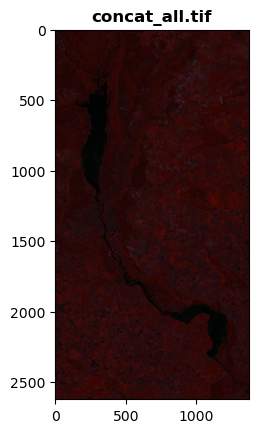

In [14]:
def show_img(tif_path, scale=8):
    if os.path.exists(tif_path):
        with rasterio.open(tif_path) as img:
            height = img.height // scale
            width = img.width // scale
            preview = img.read(
                [4, 2, 1],
                out_shape=(3, height, width)
            )
            show(preview, adjust=True, title=f"{os.path.basename(tif_path)}")
    else:
        print(f"!!! Файл не знайдено: {tif_path}")

show_img(r"C:\Users\User\Desktop\university\lab7\concat_all.tif")

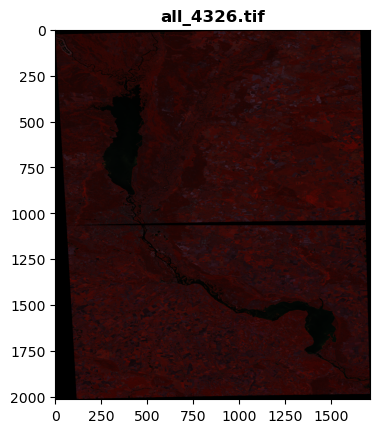

In [15]:
show_img(r"C:\Users\User\Desktop\university\lab7\all_4326.tif")

- Обрізання результуючого зображення по заданому векторному контуру.

In [27]:
def generate_roi_shapefile(save_dir):
    wkt_polygon = (
        "POLYGON(("
        "29.073321247506765 49.845775018245774, "
        "31.986007792928522 49.845775018245774, "
        "31.986007792928522 51.278667808079206, "
        "29.073321247506765 51.278667808079206, "
        "29.073321247506765 49.845775018245774"
        "))"
    )

    polygon_geom = wkt.loads(wkt_polygon)
    gdf = gpd.GeoDataFrame(geometry=[polygon_geom], crs="EPSG:4326")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    shp_path = os.path.join(save_dir, "Kyiv_ROI.shp")
    gdf.to_file(shp_path)
    print(f"Контур збережено до: {shp_path}")
    return shp_path
    
def crop_raster(raster_path, vector_path):
    if not os.path.exists(raster_path):
        print("!!! Растр не знайдено.")
        return

    if not os.path.exists(vector_path):
        print("!!! Векторний контур не знайдено.")
        return

    clipped_path = os.path.splitext(raster_path)[0] + "_ROI.tif"

    warp_cmd = [
        'gdalwarp',
        '-cutline', vector_path,
        '-crop_to_cutline',
        '-overwrite',
        raster_path,
        clipped_path
    ]

    try:
        subprocess.run(warp_cmd, check=True)
        print(f"Створено обрізаний файл: {clipped_path}")
    except subprocess.CalledProcessError as err:
        print(f"!!! Помилка обрізання: {err}")

base_dir = r"C:\Users\User\Desktop\university\lab7"
shapefile_dir = os.path.join(base_dir, "shapes")

raster_4326 = os.path.join(base_dir, "all_4326.tif")
raster_concat = os.path.join(base_dir, "concat_all.tif")

roi_shp = generate_roi_shapefile(shapefile_dir)
crop_raster(raster_4326, roi_shp)
crop_raster(raster_concat, roi_shp)

Контур збережено до: C:\Users\User\Desktop\university\lab7\shapes\Kyiv_ROI.shp
Створено обрізаний файл: C:\Users\User\Desktop\university\lab7\all_4326_ROI.tif
Створено обрізаний файл: C:\Users\User\Desktop\university\lab7\concat_all_ROI.tif


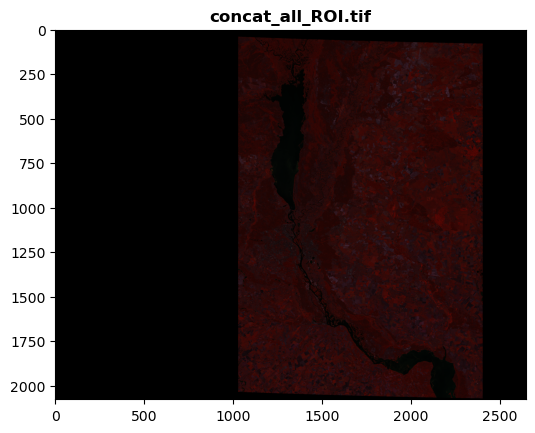

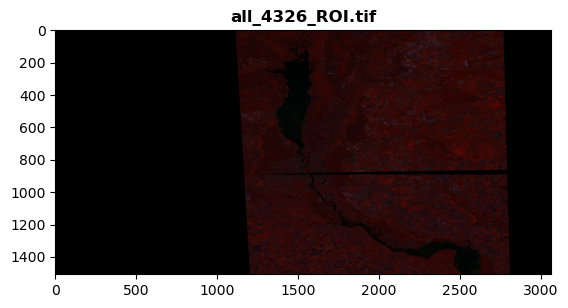

In [28]:
show_img(r"C:\Users\User\Desktop\university\lab7\concat_all_ROI.tif")
show_img(r"C:\Users\User\Desktop\university\lab7\all_4326_ROI.tif")